In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

### Load the Data

In [2]:
tiktok = pd.read_csv("tiktok_reports.csv")
tiktok = tiktok.dropna()

### Separate Claims and Opinions

In [3]:
claims = tiktok[tiktok['claim_status'] == 'claim']
opinions = tiktok[tiktok['claim_status'] == 'opinion']

### Acquire Transcipts

In [4]:
opinions_text = opinions['video_transcription_text']
claims_text = claims['video_transcription_text']
common_words = pd.read_csv("most_common_words.csv")

### Sort by Occurences of Words

In [5]:
opinions_text = opinions_text.str.split(' ')
opinions_text = opinions_text.explode().reset_index()
opinions_text = opinions_text[opinions_text['video_transcription_text'] != '']
opinions_text = pd.merge(opinions_text, common_words, left_on='video_transcription_text', right_on='word', how="outer", indicator=True).query('_merge=="left_only"')
opinions_text = opinions_text.groupby('video_transcription_text').count().sort_values(by=['index'], ascending=False)
opinions_text = opinions_text.drop(['word', '_merge'], axis=1)
opinions_text.head()

,index
video_transcription_text,
is,8339
are,2373
colleagues',1206
friends',1181
family's,1160


In [6]:
claims_text = claims_text.str.split(' ')
claims_text = claims_text.explode().reset_index()
claims_text = claims_text[claims_text['video_transcription_text'] != '']
claims_text = pd.merge(claims_text, common_words, left_on='video_transcription_text', right_on='word', how="outer", indicator=True).query('_merge=="left_only"')
claims_text = claims_text.groupby('video_transcription_text').count().sort_values(by=['index'], ascending=False)
claims_text = claims_text.drop(['word', '_merge'], axis=1)
claims_text.to_csv('claims.csv')

### Remove 100 Most Common Words

In [7]:
in_claims = pd.merge(claims_text, opinions_text, on=['video_transcription_text'], how="outer", indicator=True)
in_claims = in_claims[in_claims['_merge'] == 'left_only']
in_claims = in_claims.drop(['index_y', '_merge'], axis=1)
in_claims = in_claims.rename(columns={'index_x': "occurences"}).astype(int)

In [8]:
in_opinions = pd.merge(opinions_text, claims_text, on=['video_transcription_text'], how="outer", indicator=True)
in_opinions = in_opinions[in_opinions['_merge'] == 'left_only']
in_opinions = in_opinions.drop(['index_y', '_merge'], axis=1)
in_opinions = in_opinions.rename(columns={'index_x': "occurences"}).astype(int)

In [9]:
in_both = pd.merge(opinions_text, claims_text, on=['video_transcription_text'], how="outer", indicator=True)
in_both = in_both[in_both['_merge'] == 'both']
in_both = in_both.drop(['index_y', '_merge'], axis=1)
in_both.to_csv('both.csv')

### Acquire Top 10 Highest Occurences of Words

In [10]:
claims_occurences = in_claims['occurences'][0:10,]
opinions_occurences = in_opinions['occurences'][0:10,]

### Create Bar Plots

Text(0, 0.5, 'Occurences')

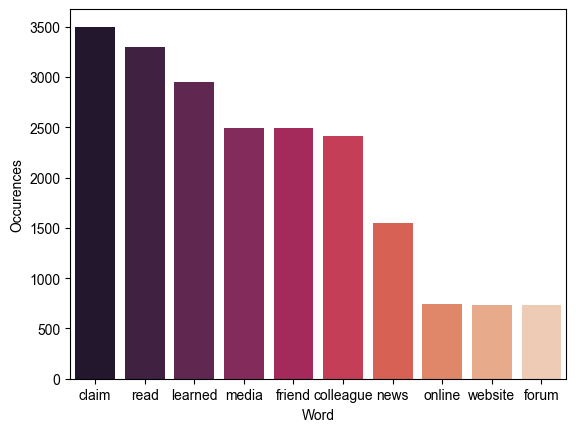

In [11]:
sns.barplot(x=claims_occurences.index, y=claims_occurences.values, hue=claims_occurences.index, palette="rocket")
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})
plt.xlabel('Word')
plt.ylabel('Occurences')

Text(0, 0.5, 'Occurences')

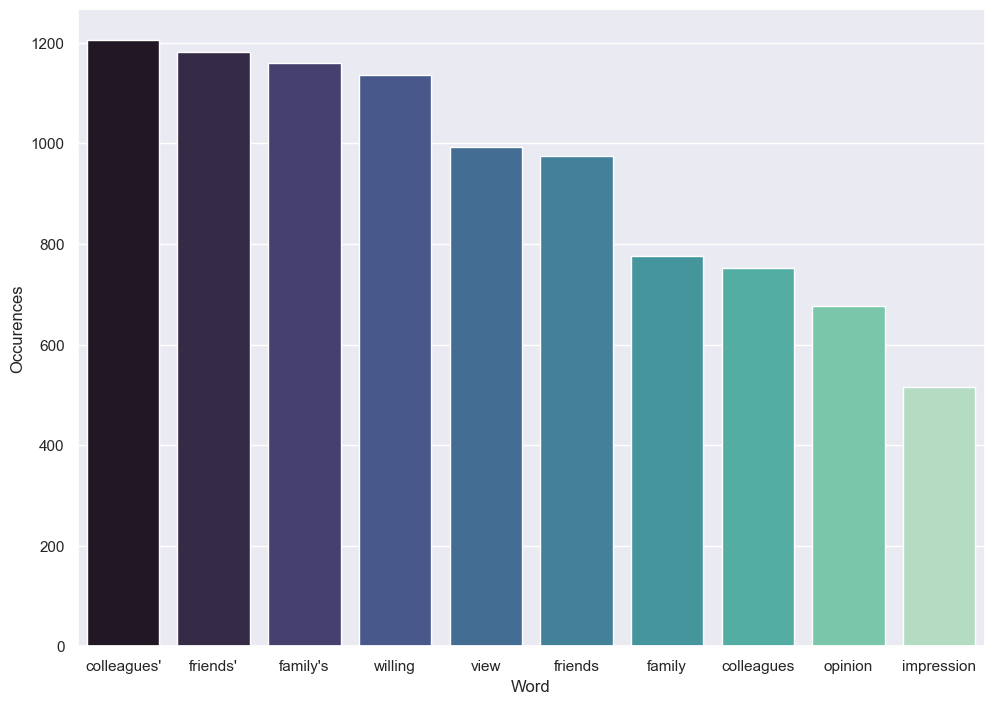

In [12]:
sns.barplot(x=opinions_occurences.index, y=opinions_occurences.values, hue=opinions_occurences.index, palette="mako")
plt.xlabel('Word')
plt.ylabel('Occurences')

### Prepare Data for Regression

In [13]:
corr_data = tiktok[['claim_status','video_duration_sec', 'video_view_count', 'video_like_count', 'video_share_count', 'video_download_count', 'video_comment_count']]
corr_data = corr_data[(corr_data != 0).all(axis=1)]
corr_data['claim_status'] = corr_data['claim_status'].replace('claim', 0)
corr_data['claim_status'] = corr_data['claim_status'].replace('opinion', 1)

In [14]:
corr_data['log_like_count'] = np.log10(tiktok['video_like_count'])
corr_data['log_comment_count'] = np.log10(tiktok['video_comment_count'])
corr_data['log_view_count'] = np.log10(tiktok['video_view_count'])
corr_data['log_share_count'] = np.log10(tiktok['video_share_count'])
corr_data['log_download_count'] = np.log10(tiktok['video_download_count'])
corr_data

c:\Users\Spencer\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Spencer\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Spencer\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Spencer\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,claim_status,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,log_like_count,log_comment_count,log_view_count,log_share_count,log_download_count
1,0,32,140877.0,77355.0,19034.0,1161.0,684.0,4.888488,2.835056,5.148840,4.279530,3.064832
2,0,31,902185.0,97690.0,2858.0,833.0,329.0,4.989850,2.517196,5.955296,3.456062,2.920645
3,0,25,437506.0,239954.0,34812.0,1234.0,584.0,5.380128,2.766413,5.640984,4.541729,3.091315
4,0,19,56167.0,34987.0,4110.0,547.0,152.0,4.543907,2.181844,4.749481,3.613842,2.737987
5,0,35,336647.0,175546.0,62303.0,4293.0,1857.0,5.244391,3.268812,5.527175,4.794509,3.632761
...,...,...,...,...,...,...,...,...,...,...,...,...
19078,1,34,3330.0,1329.0,326.0,32.0,8.0,3.123525,0.903090,3.522444,2.513218,1.505150
19079,1,49,6067.0,423.0,81.0,8.0,2.0,2.626340,0.301030,3.782974,1.908485,0.903090
19081,1,50,734.0,102.0,7.0,2.0,1.0,2.008600,0.000000,2.865696,0.845098,0.301030
19082,1,8,3394.0,655.0,123.0,11.0,4.0,2.816241,0.602060,3.530712,2.089905,1.041393


### Create a Correlation Matrix of Selected Variables

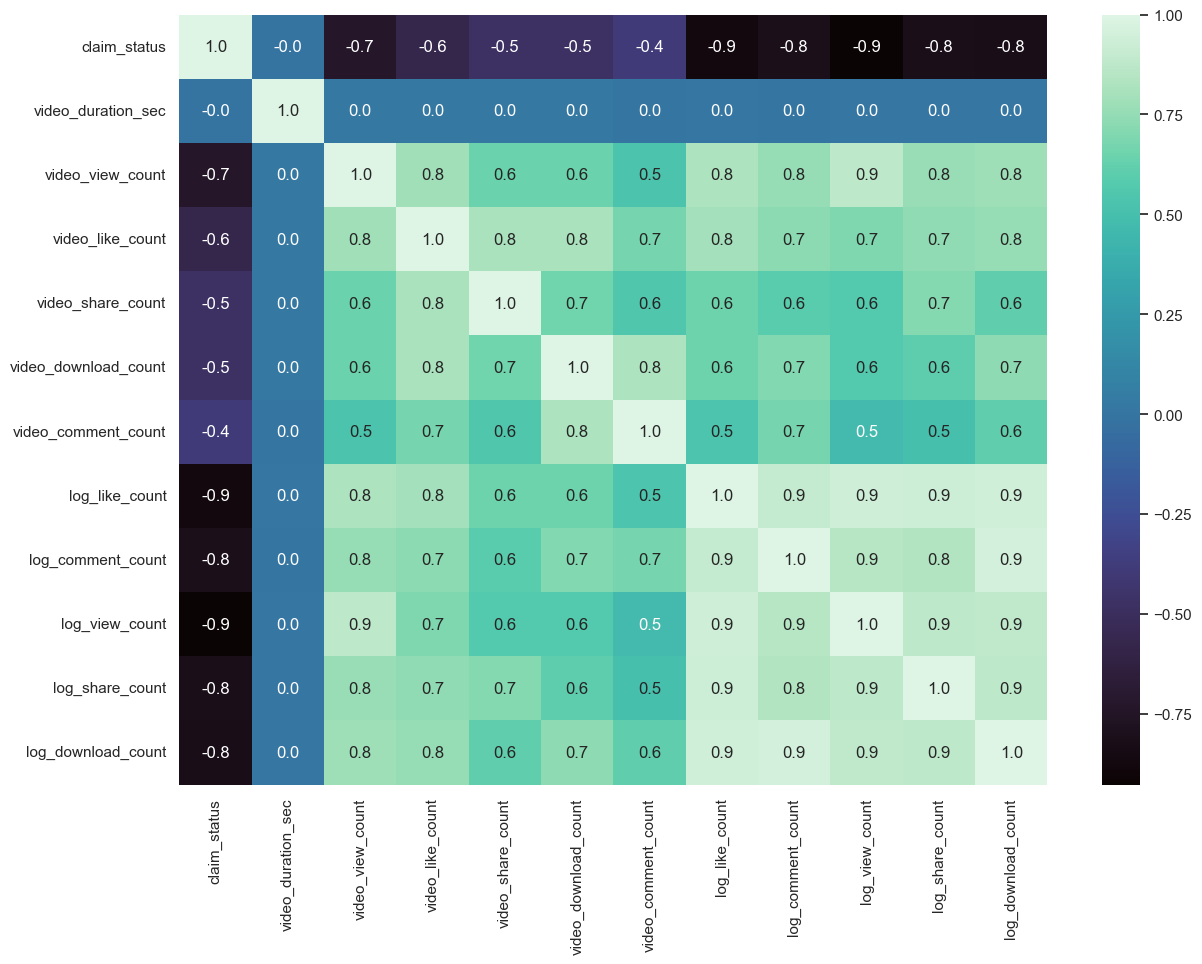

In [15]:
f,ax = plt.subplots(figsize=(14,10))
sns.heatmap(corr_data.corr(), annot = True, fmt = ".1f", ax=ax, cmap="mako")
plt.show()

### Implement Forward Model Selection Function

In [16]:
#Adapted from https://planspace.org/20150423-forward_selection_with_statsmodels/
import statsmodels.formula.api as smf
def forward_selected(data, response):
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

### Preview Model along with $R^2$

In [17]:
model = forward_selected(corr_data, 'claim_status')
print(model.model.formula)
print(model.rsquared_adj)

claim_status ~ log_view_count + video_view_count + log_comment_count + video_comment_count + log_download_count + log_like_count + video_like_count + video_download_count + video_duration_sec + 1
0.8930537905611584


### Regex to extract variable names

In [18]:
variables = re.findall("[a-zA-Z_]+", model.model.formula)

### Preparing Model for Regression

In [19]:
X = corr_data[variables[1:10]]
y = corr_data[variables[0]]

### Observing VIFs
Due to high correlation shown in correlation matrix

In [20]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
vif_data

,feature,VIF
0,log_view_count,297.917331
1,video_view_count,9.132470
2,log_comment_count,37.092374
3,video_comment_count,5.186212
4,log_download_count,118.834301
5,log_like_count,439.603666
6,video_like_count,11.887417
7,video_download_count,9.600452
8,video_duration_sec,4.835708


### Previewing Summary Statistics

In [21]:
tiktok_model = sm.OLS(y, X).fit()
print(tiktok_model.summary())

                                 OLS Regression Results                                
Dep. Variable:           claim_status   R-squared (uncentered):                   0.748
Model:                            OLS   Adj. R-squared (uncentered):              0.748
Method:                 Least Squares   F-statistic:                              5155.
Date:                Thu, 12 Sep 2024   Prob (F-statistic):                        0.00
Time:                        01:48:41   Log-Likelihood:                         -4087.2
No. Observations:               15639   AIC:                                      8192.
Df Residuals:                   15630   BIC:                                      8261.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

### Setting up and Running Model

In [22]:
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100)
reg_model = linear_model.LinearRegression()
reg_model = LinearRegression().fit(X_train, y_train)

In [23]:
y_pred= reg_model.predict(X_test)  
x_pred= reg_model.predict(X_train) 

### Adjusting Values to Nearest Claim Status

In [24]:
reg_model_diff = pd.DataFrame({'Actual value': y_test, 'Predicted value': y_pred})
reg_model_diff.loc[(reg_model_diff['Predicted value'] > 0.5), 'Adjusted'] = 1      
reg_model_diff.loc[(reg_model_diff['Predicted value'] < 0.5), 'Adjusted'] = 0
reg_model_diff['Adjusted'] = reg_model_diff['Adjusted'].astype('Int64')
reg_model_diff

,Actual value,Predicted value,Adjusted
10350,1,1.136096,1
15417,1,0.983417,1
77,0,0.007000,0
5403,0,0.063168,0
4847,0,-0.031313,0
...,...,...,...
7341,0,0.060689,0
14199,1,1.044464,1
5162,0,-0.044648,0
5933,0,0.026471,0


In [25]:
reg_model_diff.loc[(reg_model_diff['Actual value'] == reg_model_diff['Adjusted']), 'Correctness'] = True      
reg_model_diff.loc[(reg_model_diff['Actual value'] != reg_model_diff['Adjusted']), 'Correctness'] = False
reg_model_result = reg_model_diff[reg_model_diff['Correctness'] == False].shape
reg_model_diff

C:\Users\Spencer\AppData\Local\Temp\ipykernel_13516\3676295626.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  reg_model_diff.loc[(reg_model_diff['Actual value'] == reg_model_diff['Adjusted']), 'Correctness'] = True


,Actual value,Predicted value,Adjusted,Correctness
10350,1,1.136096,1,True
15417,1,0.983417,1,True
77,0,0.007000,0,True
5403,0,0.063168,0,True
4847,0,-0.031313,0,True
...,...,...,...,...
7341,0,0.060689,0,True
14199,1,1.044464,1,True
5162,0,-0.044648,0,True
5933,0,0.026471,0,True


### Number of Prediction Errors

In [26]:
reg_model_result[0]

74

### Accuracy of Model

In [27]:
print('Accuracy: %', 100-(reg_model_result[0]/corr_data.shape[0]*100))

Accuracy: % 99.5268239657267


### MSE and MAE Results

In [28]:
print('mean squared error (MSE): ', mean_squared_error(y_test, y_pred))
print('mean absolute error (MAE): ', mean_absolute_error(y_test, y_pred))  

mean squared error (MSE):  0.026461742700947703
mean absolute error (MAE):  0.10469052539277736
